In [2]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.tiny_image_net_data_module import TinyImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [3]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [4]:
data_dir = "data"

dm = TinyImageNetDataModule(
    data_dir=os.path.join(data_dir, "tiny-imagenet-200"), 
    batch_size_train=64,
    batch_size_val=64,
    batch_size_test=64,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True
)

## Create a ContextEncoder model from scratch

In [3]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True)

## Or load it from a checkpoint

In [5]:
model = ContextEncoder.load_from_checkpoint("checkpoints/tiny_imagenet/epoch=54-step=171930.ckpt") # change the path to your checkpoint
model.enable_save_image_per_epoch()
model.to("cuda")

ContextEncoder(
  (psnr_metric): PeakSignalNoiseRatio()
  (joint_loss): JointLoss(
    (rec_loss): ReconstructionLoss()
    (adv_loss): AdversarialLoss()
  )
  (rec_loss): ReconstructionLoss()
  (adv_loss): AdversarialLoss()
  (generator): AdversarialGenerator(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (

## Train it

In [7]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/tiny_imagenet',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Display some images and evaluate the model performances

Here the results of this cell are after 19 epochs on the Tiny Image Net dataset (10x less images compared to Image Net) in 64x64

- **Number of steps**: 86 749
- **Time**: 2h30
- **Observation (with tensorboard)**: Note that this dataset is quite small compared to the full Image Net, we have 100 000 images. There is overfitting starting at epoch 8. So in the cell after this one we will display results at epoch 8 to compare. This early overfitting is maybe related to the size of images (the paper use larger images, but it's difficult to run it on our machines). We should also note that this paper provide few information on hyperparameters (e.g. betas for Adam). So differences can also come from here.

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:05<00:00, 29.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           15.666199684143066
        test_loss            4.789642810821533
        test_psnr           15.668519020080566
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


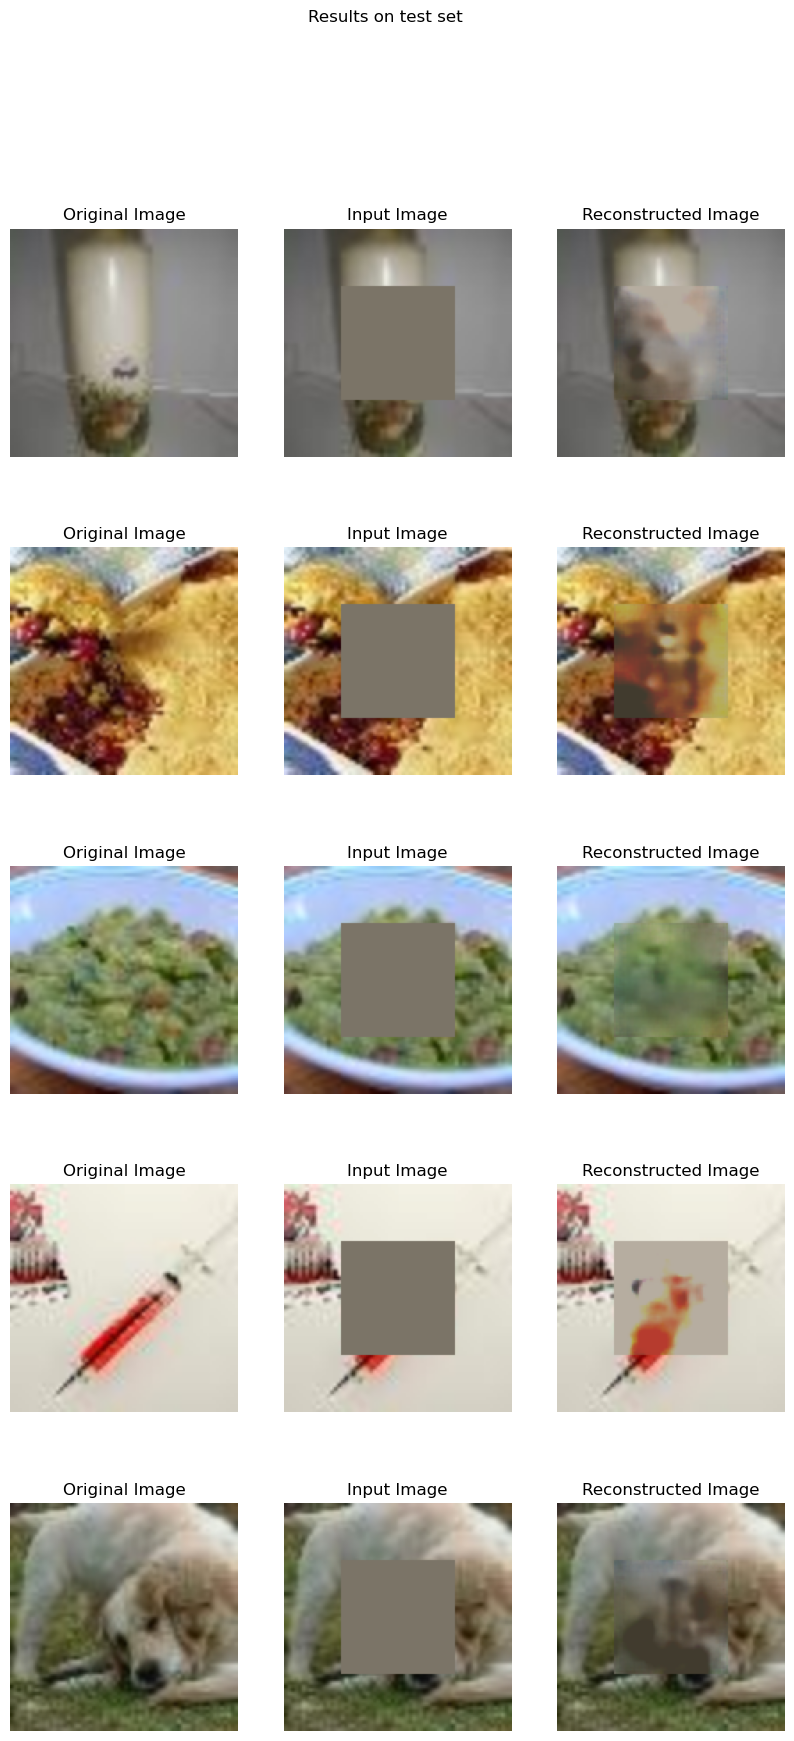

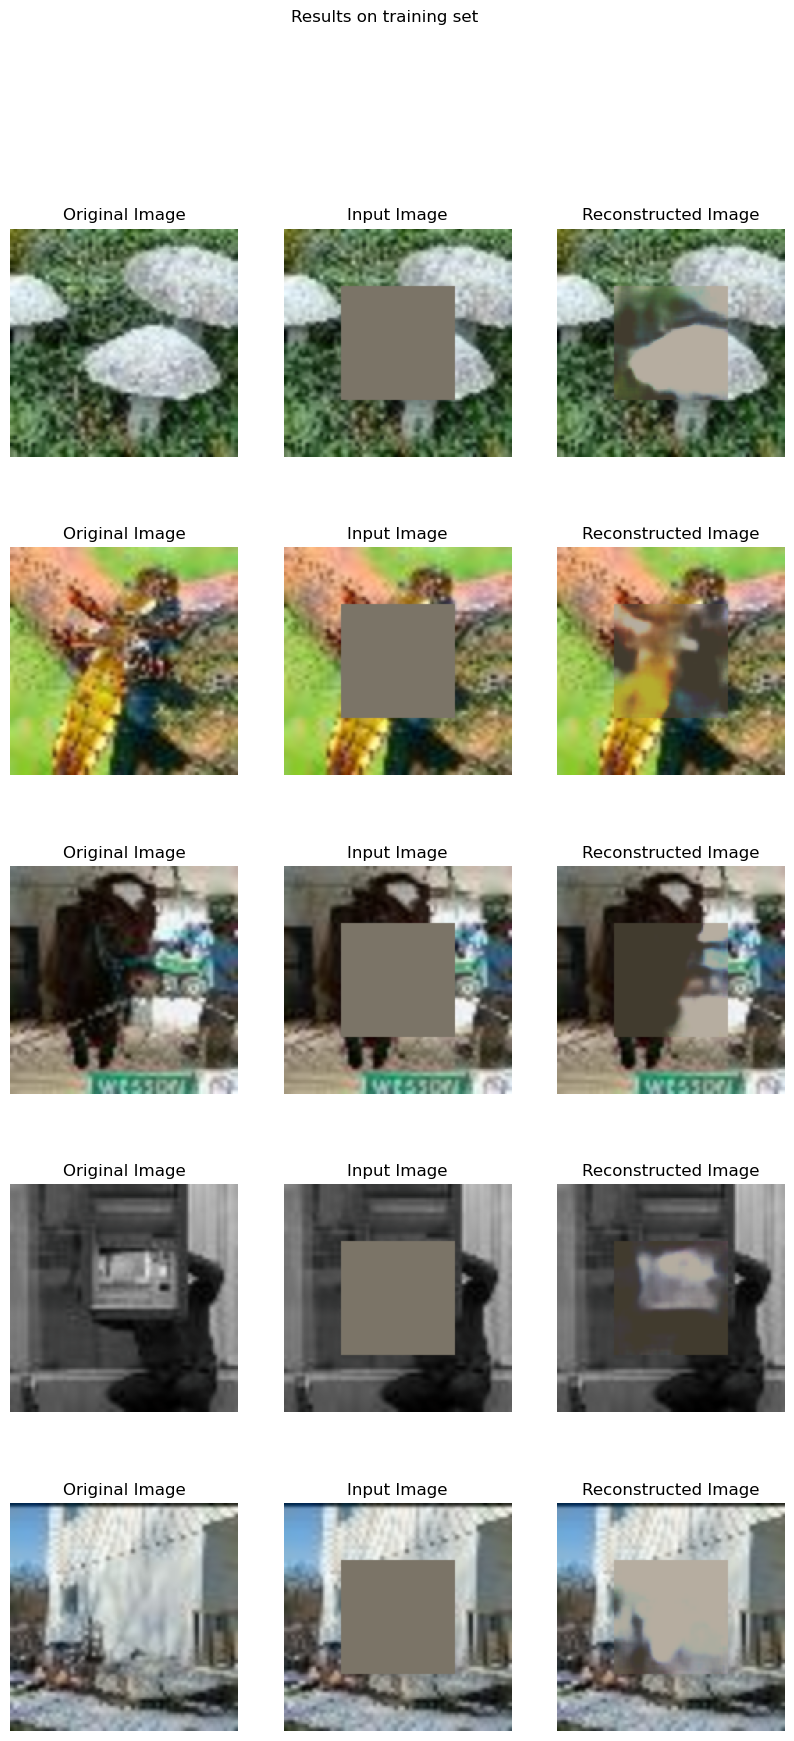

In [8]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)

## Results on the best validation loss model

Here the results of this cell are after 5 epochs on the Tiny Image Net dataset (10x less images compared to Image Net) in 64x64.
When we did run this test we didn't save per epoch the model yet so we can't display the results. But you can see the GIF in results_images to see the evolution on one image of the validation set.

- **Number of steps**: around 12 500
- **Time**: around 20min

In [ ]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)